In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt
import random
import os

2022-03-18 12:03:18.186434: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
train_input_dir = "data/train/huawei_raw"
train_target_dir = "data/train/canon"
test_input_dir = "data/test/huawei_raw"
test_target_dir = "data/test/canon"
img_size = (224, 224)
dlsr_scale = 2
input_channels = 4
output_channels = 3
batch_size = 8

input_img_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".jpg")
    ]
)

test_input_img_paths = sorted(
    [
        os.path.join(test_input_dir, fname)
        for fname in os.listdir(test_input_dir)
        if fname.endswith(".png")
    ]
)
test_target_img_paths = sorted(
    [
        os.path.join(test_target_dir, fname)
        for fname in os.listdir(test_target_dir)
        if fname.endswith(".jpg")
    ]
)


print("Number of samples:", len(input_img_paths))
print("Number test of samples:", len(test_input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 46839
Number test of samples: 1204
data/train/huawei_raw/0.png | data/train/canon/0.jpg
data/train/huawei_raw/1.png | data/train/canon/1.jpg
data/train/huawei_raw/10.png | data/train/canon/10.jpg
data/train/huawei_raw/100.png | data/train/canon/100.jpg
data/train/huawei_raw/1000.png | data/train/canon/1000.jpg
data/train/huawei_raw/10000.png | data/train/canon/10000.jpg
data/train/huawei_raw/10001.png | data/train/canon/10001.jpg
data/train/huawei_raw/10002.png | data/train/canon/10002.jpg
data/train/huawei_raw/10003.png | data/train/canon/10003.jpg
data/train/huawei_raw/10004.png | data/train/canon/10004.jpg


In [3]:
def plt_display(image, title):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    a.set_title(title)

In [4]:
from isp.dataset.loader import HuaveiLoader

val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, train_input_img_paths, train_target_img_paths
)
val_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, val_input_img_paths, val_target_img_paths
)
test_gen = HuaveiLoader(
    batch_size, img_size, dlsr_scale, test_input_img_paths, test_target_img_paths
)

In [5]:
x, y = train_gen.__getitem__(0)

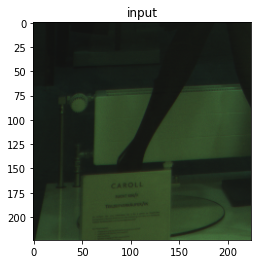

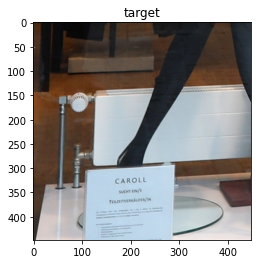

In [6]:
plt_display(x[0][:,:,0:3], 'input')
plt_display(y[0], 'target')

In [7]:
from isp.models.unet import get_model

model = get_model(input_shape=(224, 224, 4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 1184        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 32) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

2022-03-18 12:03:28.295962: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-18 12:03:28.296500: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-18 12:03:28.332097: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-18 12:03:28.332233: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:09:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-03-18 12:03:28.332242: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-03-18 12:03:28.333079: I tensorflow/stream_executor/platfor

In [8]:
from isp.utils.losses import mssim, color, exp_fusion, vgg_loss

losses = {
    'mae_out': 'mae',
    'mssim_out': mssim,
    'color_out': color,
    'exp_out': exp_fusion,
    'vgg_out': vgg_loss,
}

model.compile(optimizer="adam", loss=losses)

In [ ]:
epochs = 4

callbacks = [
    keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)
]


model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

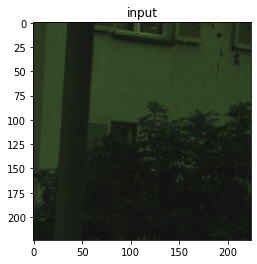

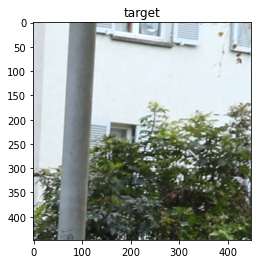

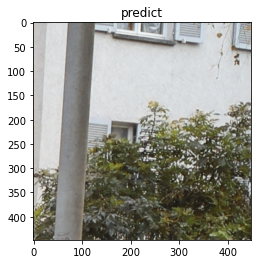

In [25]:
x, y = train_gen.__getitem__(0)
preds = model.predict(x)
plt_display(x[2][:,:,0:3], 'input')
plt_display(y[2], 'target')
plt_display(preds['vgg_out'][2], 'predict')

In [22]:
model.save('unet_5loss.h5')

In [26]:
from isp.models.unet_1loss import get_model

model = get_model(input_shape=(224, 224, 4))
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 4) 0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 224, 224, 32) 1184        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 224, 224, 32) 9248        conv2d_26[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 32) 0           conv2d_27[0][0]                  
____________________________________________________________________________________________

In [27]:
from isp.utils.losses import mssim, color, exp_fusion, vgg_loss

def main_loss(y_true, y_pred):
    return tf.keras.losses.mean_absolute_error(y_true, y_pred) + mssim(y_true, y_pred) + color(y_true, y_pred) + exp_fusion(y_true, y_pred) + vgg_loss(y_true, y_pred)

model.compile(optimizer="adam", loss=main_loss)

In [28]:
epochs = 4

callbacks = [
    keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)
]


model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/4
5729/5729 [==============================] - 1755s 306ms/step - loss: 0.9809 - val_loss: 0.8355
Epoch 2/4
5729/5729 [==============================] - 1754s 306ms/step - loss: 0.7999 - val_loss: 0.7949
Epoch 3/4
5729/5729 [==============================] - 1751s 306ms/step - loss: 0.7839 - val_loss: 0.7706
Epoch 4/4
5729/5729 [==============================] - 1751s 306ms/step - loss: 0.7751 - val_loss: 0.7612


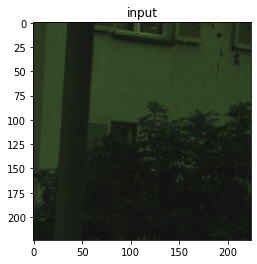

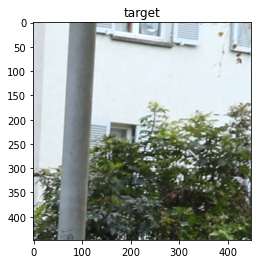

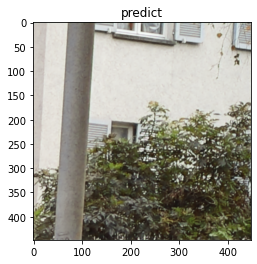

In [30]:
x, y = train_gen.__getitem__(0)
preds = model.predict(x)
plt_display(x[2][:,:,0:3], 'input')
plt_display(y[2], 'target')
plt_display(preds[2], 'predict')

In [31]:
model.save('unet_1loss.h5')

In [42]:
from isp.models.unet_1loss import get_model

model = get_model(input_shape=(None, None, 4))
model.summary()
model.compile(optimizer="adam", loss=main_loss)
model.load_weights('unet_1loss.h5')

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_78 (Conv2D)              (None, None, None, 3 1184        input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_79 (Conv2D)              (None, None, None, 3 9248        conv2d_78[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, None, None, 3 0           conv2d_79[0][0]                  
____________________________________________________________________________________________